In [ ]:
from pathlib import Path
import os, sys
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Making the reference masks

Reference map tile is `213405_1984`. 

All reference masks are stored as separate files, so merge them into a single file that has encoding

1. Fields
2. Marshes
3. Roads
4. Waterways
5. Water bodies

Stack the layers also in that order so we get correct layering.

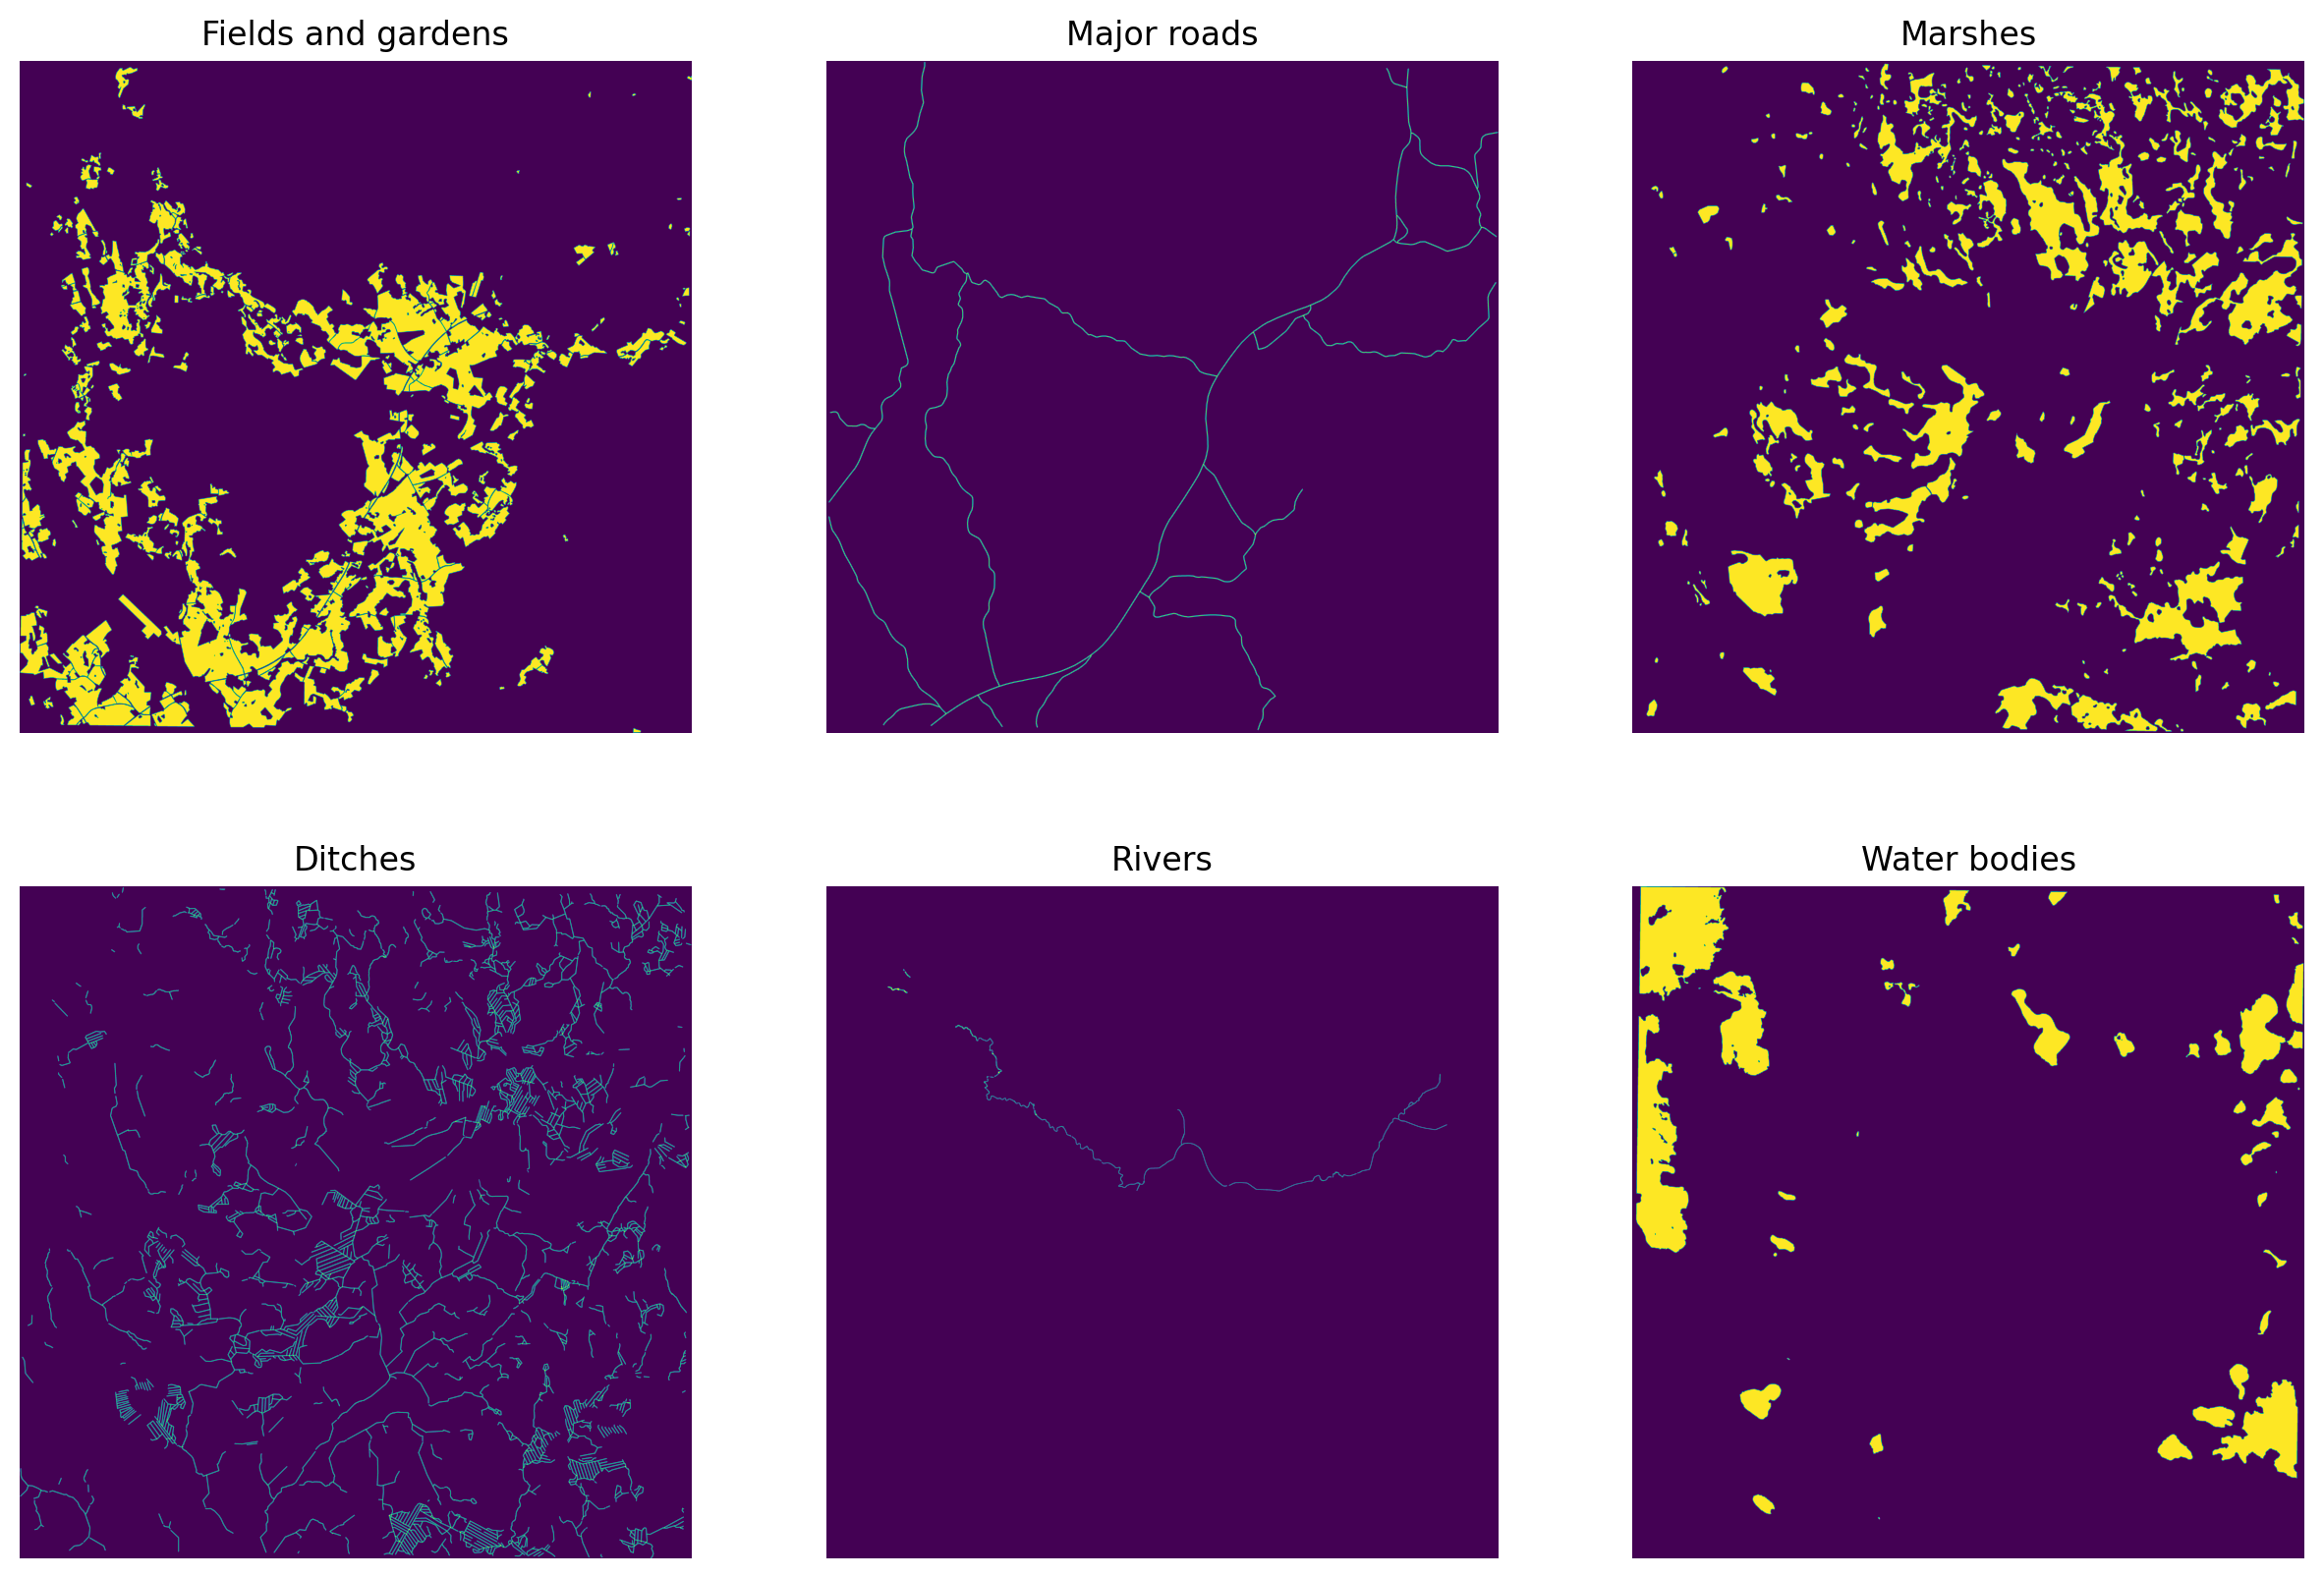

In [ ]:
ref_path = Path('../data/reference_masks/')
fields = cv2.imread(str(ref_path/'fields.png'), cv2.IMREAD_UNCHANGED)
water_bodies = cv2.imread(str(ref_path/'lakes.png'), cv2.IMREAD_UNCHANGED)
rivers = cv2.imread(str(ref_path/'rivers.png'), cv2.IMREAD_UNCHANGED)
ditches = cv2.imread(str(ref_path/'waterways.png'), cv2.IMREAD_UNCHANGED)
roads = cv2.imread(str(ref_path/'roads.png'), cv2.IMREAD_UNCHANGED)
marshes = cv2.imread(str(ref_path/'marshes.png'), cv2.IMREAD_UNCHANGED)

waterways = rivers + ditches

fig, axs = plt.subplots(2,3, figsize=(15,10), dpi=200)
for a in axs.flatten(): a.axis('off')
axs[0,0].imshow(fields)
axs[0,0].set_title('Fields and gardens')
axs[0,1].imshow(roads)
axs[0,1].set_title('Major roads')
axs[0,2].set_title('Marshes')
axs[0,2].imshow(marshes)
axs[1,0].imshow(ditches)
axs[1,0].set_title('Ditches')
axs[1,1].imshow(rivers)
axs[1,1].set_title('Rivers')
axs[1,2].imshow(water_bodies)
axs[1,2].set_title('Water bodies')

plt.show()

Stack these into a single mask.

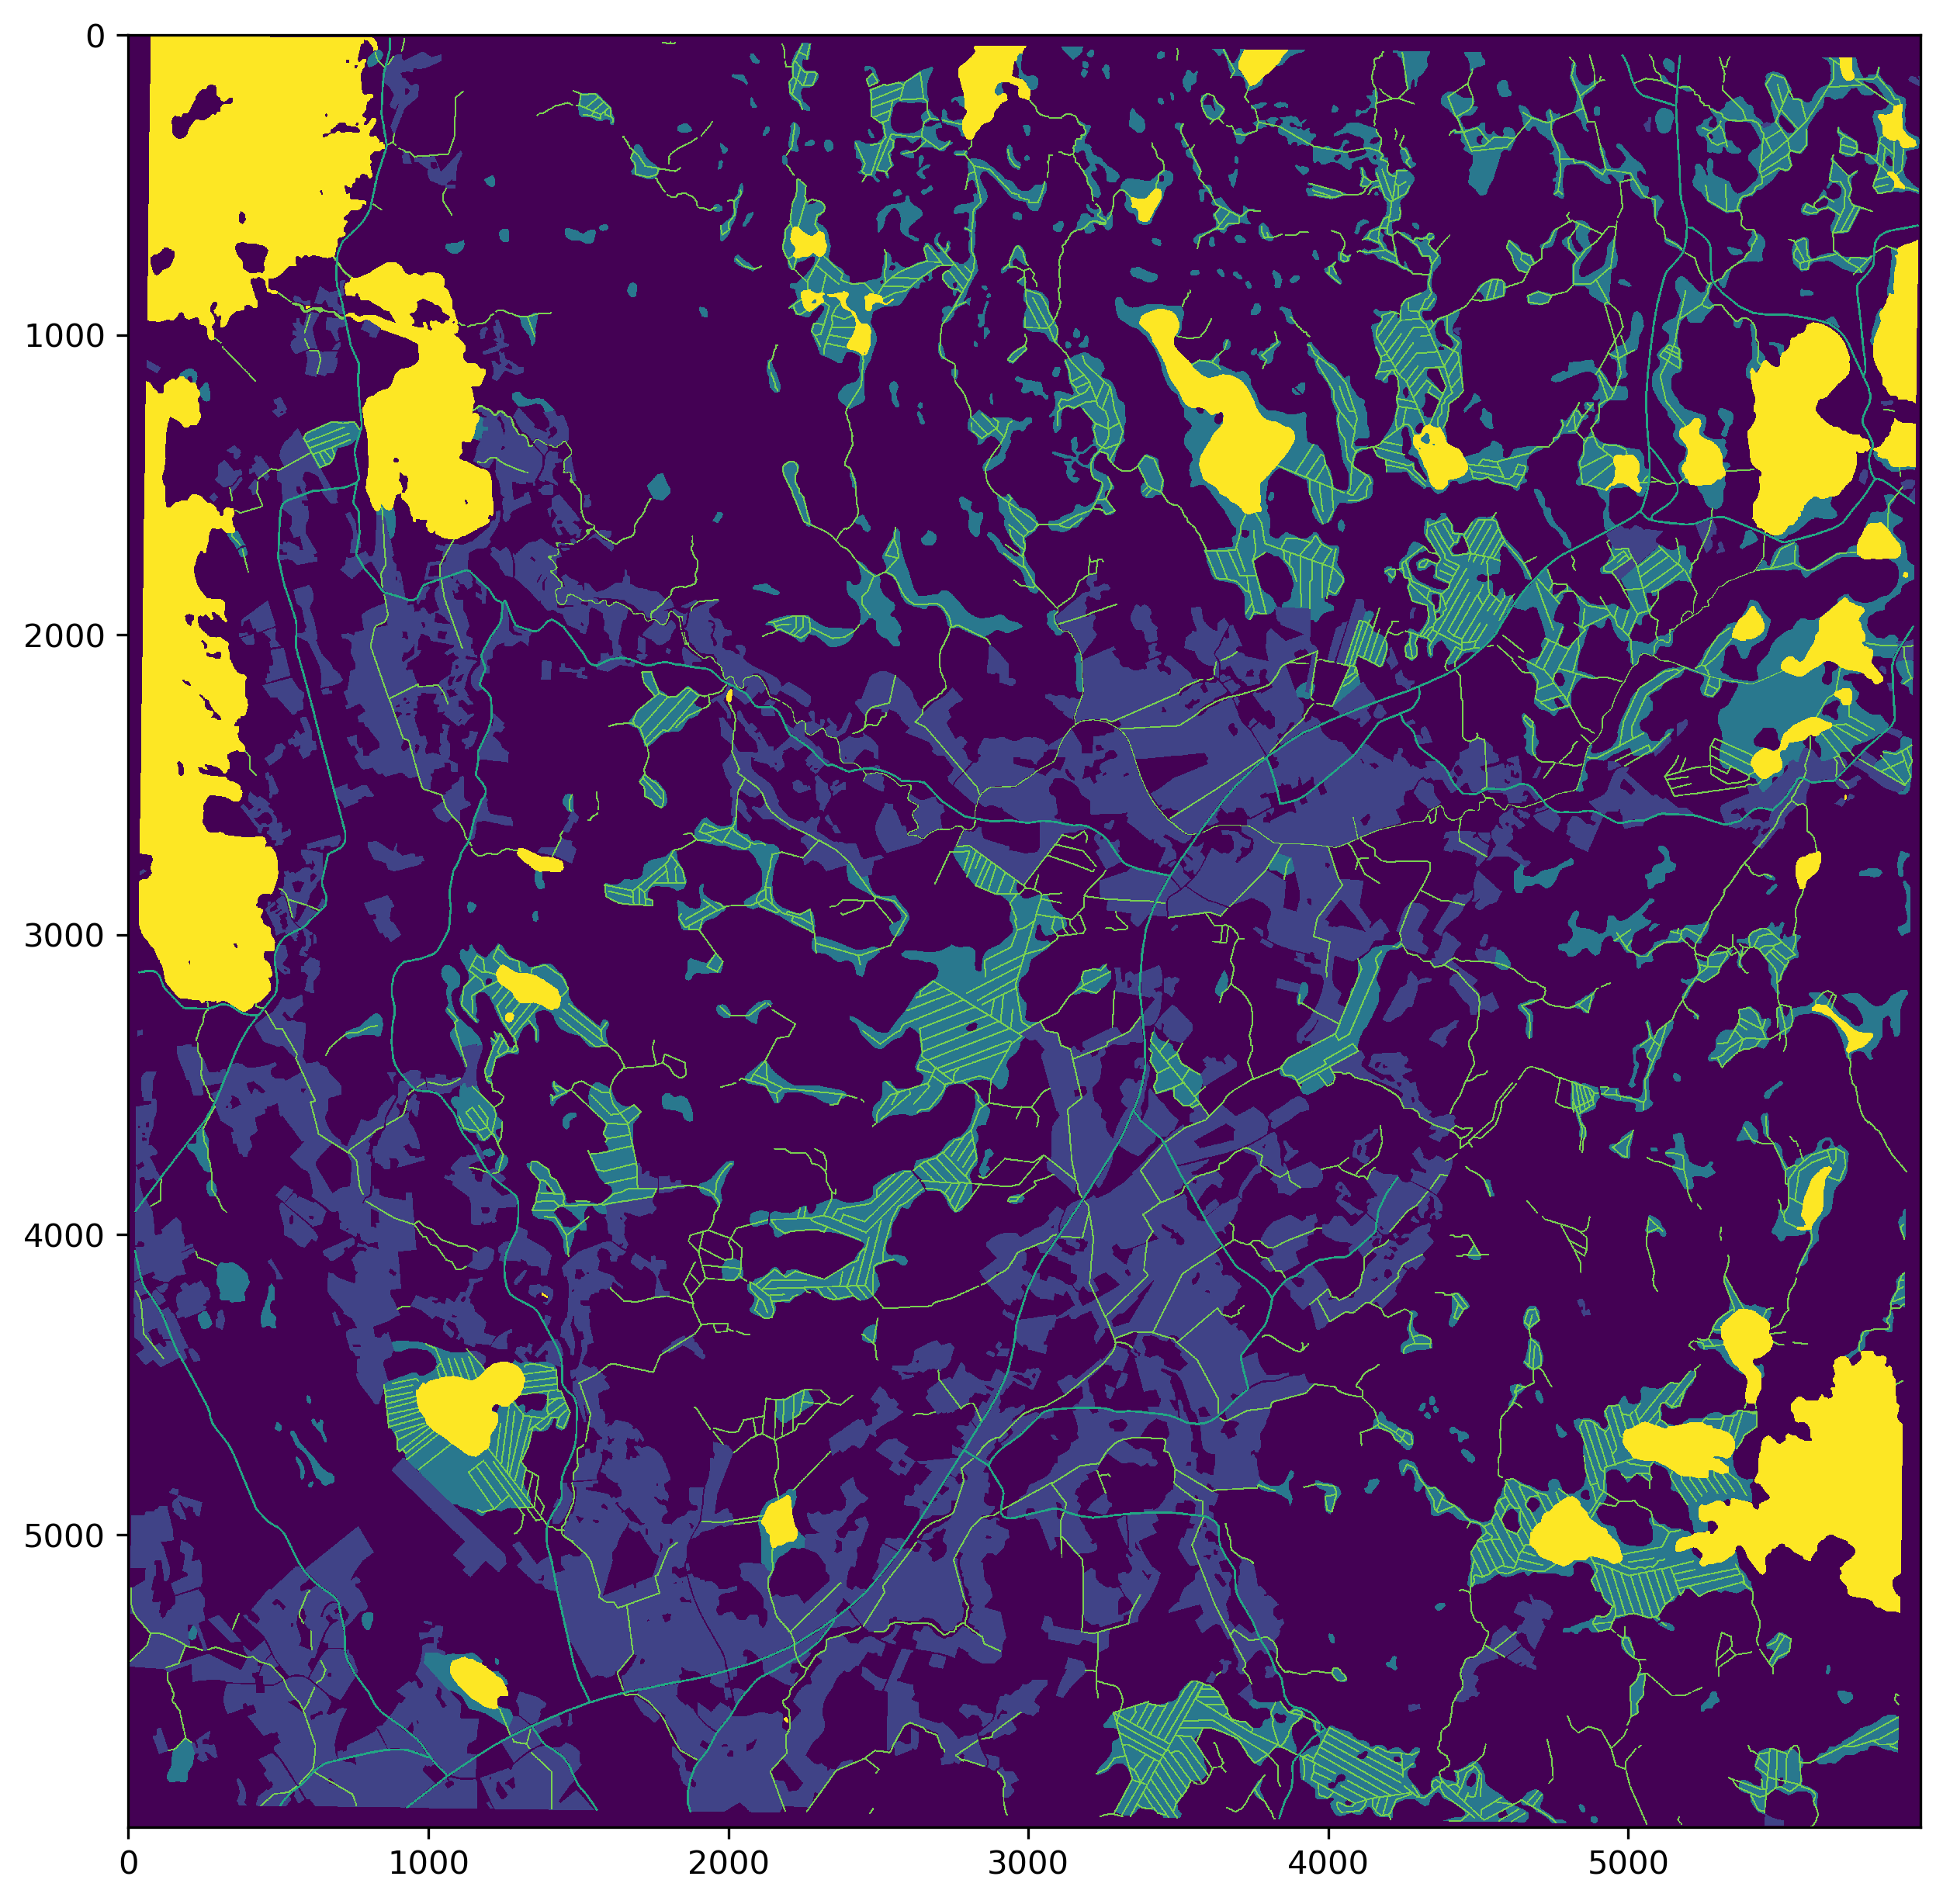

In [ ]:
outim = np.empty((fields.shape), np.uint8)
outim[fields > 0] = 1
outim[marshes > 0] = 2
outim[roads > 0] = 3
outim[waterways > 0] = 4
outim[water_bodies > 0] = 5
fig = plt.figure(figsize=(10,10), dpi=300)
plt.imshow(outim, vmin=0, vmax=5, interpolation='none')
plt.show()

Save mask.

In [ ]:
cv2.imwrite(str(ref_path/'combined_mask.png'), outim.astype('uint8'))

True

Check that pixel values are correct.

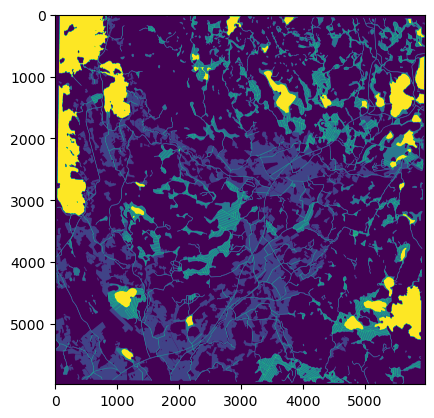

In [ ]:
mask = cv2.imread(str(ref_path/'combined_mask.png'), 0)
plt.imshow(mask, vmin=0, vmax=5)
plt.show()

# Georeference masks

Use the corresponding cropped ground control points to georeference these masks

In [ ]:
from osgeo import gdal
from pyproj import CRS, Transformer
import pandas as pd

In [ ]:
gcps = pd.read_csv(f'../data/gcps/cropped/213405_1984.jpg.points')
in_crs = CRS('EPSG:4326')
out_crs = CRS('EPSG:3067')
transformer = Transformer.from_crs(in_crs, out_crs, always_xy=True)
gcp_list = []
for row in gcps.itertuples():
    tfmd_x, tfmd_y = transformer.transform(row.mapX, row.mapY)
    gcp_list.append(gdal.GCP(tfmd_x, tfmd_y, 1, row.pixelX, row.pixelY))

translate_kwargs = {
    'GCPs': gcp_list,
    'format': 'GTIFF',
    'bandList': [1],
    'outputType': gdal.gdalconst.GDT_Int16
}

inpath = '../data/reference_masks/combined_mask.png'
outpath = '../data/reference_masks/combined_mask.tif'

gdal.Translate(outpath, inpath, **translate_kwargs)
gdal.Warp(outpath, outpath, options='-r near -tps -co COMPRESS=LZW -t_srs EPSG:3067')

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *'> >

In [ ]:
import rasterio as rio
import rasterio.plot as rioplot

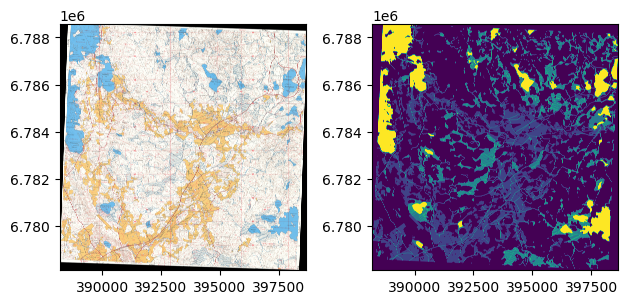

In [ ]:
fig, ax = plt.subplots(1,2)
refmap = rio.open('../data/maps/aligned_maps/213405_1984.tif')
rioplot.show(refmap, ax=ax[0])
refmap.close()
refmask = rio.open(outpath)
rioplot.show(refmask, ax=ax[1])
refmask.close()
plt.tight_layout()
plt.show()

# Tile masks and reference map

Use around half of the map as training and validation data and rest as test data.

In [ ]:
from rasterio.windows import Window

Resulting images are 6167x6167 pixels, so with 224x224 pixel images, 27x27 grid can be extracted.

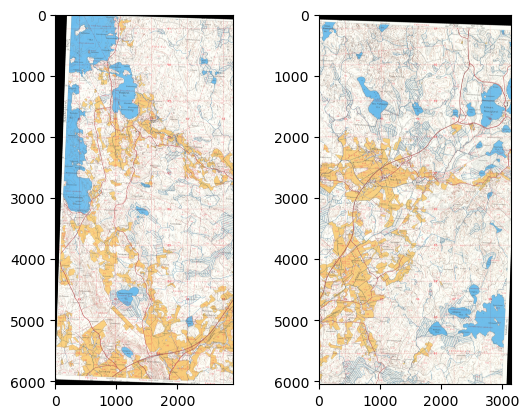

In [ ]:
train_window = Window.from_slices((0, 224*27), (0, 224*13))
val_window = Window.from_slices((0, 224*27), (224*13, 224*27))

with rio.open('../data/maps/aligned_maps/213405_1984.tif') as src:
    trainw = src.read(window=train_window)
    valw = src.read(window=val_window)
    
fig, axs = plt.subplots(1,2)
axs[0].imshow(np.moveaxis(trainw,0,-1))
axs[1].imshow(np.moveaxis(valw,0,-1))
plt.show()

In [ ]:
with rio.open('../data/maps/aligned_maps/213405_1984.tif') as src:
    train_kwargs = src.meta.copy()
    train_kwargs.update({
        'height': train_window.height,
        'width': train_window.width,
        'transform': rio.windows.transform(train_window, src.transform)
    })
    with rio.open('../data/processed/train_map.tif', 'w', **train_kwargs) as dst:
        dst.write(src.read(window=train_window))
        
    val_kwargs = src.meta.copy()
    val_kwargs.update({
        'height': val_window.height,
        'width': val_window.width,
        'transform': rio.windows.transform(val_window, src.transform)
    })
    with rio.open('../data/processed/val_map.tif', 'w', **val_kwargs) as dst:
        dst.write(src.read(window=val_window))
        
with rio.open(outpath) as src:
    train_kwargs = src.meta.copy()
    train_kwargs.update({
        'height': train_window.height,
        'width': train_window.width,
        'transform': rio.windows.transform(train_window, src.transform)
    })
    with rio.open('../data/processed/train_mask.tif', 'w', **train_kwargs) as dst:
        dst.write(src.read(window=train_window))
        
    val_kwargs = src.meta.copy()
    val_kwargs.update({
        'height': val_window.height,
        'width': val_window.width,
        'transform': rio.windows.transform(val_window, src.transform)
    })
    with rio.open('../data/processed/val_mask.tif', 'w', **val_kwargs) as dst:
        dst.write(src.read(window=val_window))

Tile our training data

In [ ]:
from drone_detector.processing.tiling import Tiler
import random

In [ ]:
tilesize = 224
outpath = Path('../data/processed/train')
trainmap_fn = '../data/processed/train_map.tif'
trainmask_fn = '../data/processed/train_mask.tif'
map_tiler = Tiler(outpath=outpath, gridsize_x=tilesize, gridsize_y=tilesize, overlap=(0,0))
map_tiler.tile_raster(trainmap_fn)

0it [00:00, ?it/s]

In [ ]:
map_tiler.raster_path = outpath/'mask_tiles'
map_tiler.tile_raster(trainmask_fn)

0it [00:00, ?it/s]

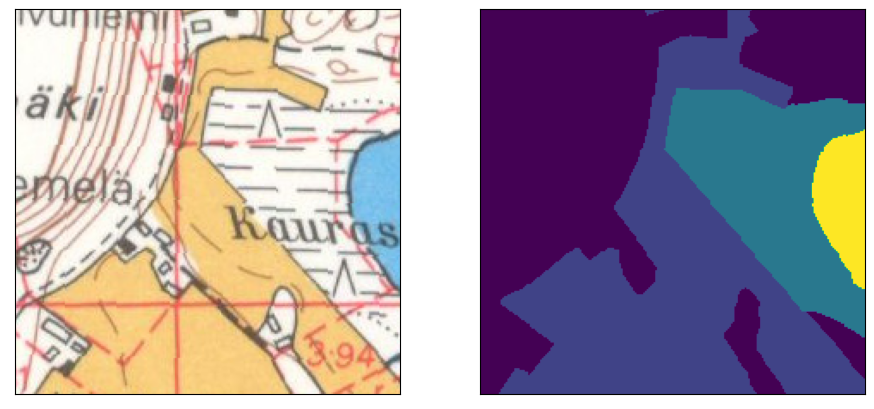

In [ ]:
ex_file = random.sample(os.listdir(outpath/'raster_tiles'), 1)[0]
fig, axs = plt.subplots(1,2, figsize=(11,5))
for a in axs:
    a.set_xticks([])
    a.set_yticks([])
with rio.open(f"../data/processed/train/raster_tiles/{ex_file}") as im:
    rioplot.show(im, ax=axs[0])
with rio.open(f"../data/processed/train/mask_tiles/{ex_file}") as mask:
    rioplot.show(mask, ax=axs[1])
    maskvals = mask.read()

Then validation data

In [ ]:
tilesize = 224
outpath = Path('../data/processed/val')
valmap_fn = '../data/processed/val_map.tif'
valmask_fn = '../data/processed/val_mask.tif'
map_tiler = Tiler(outpath=outpath, gridsize_x=tilesize, gridsize_y=tilesize, overlap=(0,0))
map_tiler.tile_raster(valmap_fn)

0it [00:00, ?it/s]

In [ ]:
map_tiler.raster_path = outpath/'mask_tiles'
map_tiler.tile_raster(valmask_fn)

0it [00:00, ?it/s]

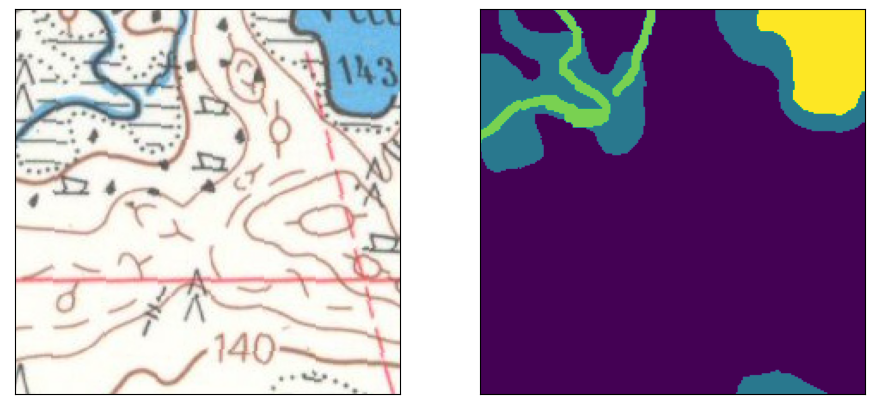

In [ ]:
ex_file = random.sample(os.listdir(outpath/'raster_tiles'), 1)[0]
fig, axs = plt.subplots(1,2, figsize=(11,5))
for a in axs:
    a.set_xticks([])
    a.set_yticks([])
with rio.open(outpath/"raster_tiles"/ex_file) as im:
    rioplot.show(im, ax=axs[0])
with rio.open(outpath/"mask_tiles"/ex_file) as mask:
    rioplot.show(mask, ax=axs[1])